## Project 1


### Import Dependencies

In [9]:
# Import libraries and dependencies
!pip install yahoo_fin
import os
import pandas as pd
import alpaca_trade_api as tradeapi
import datetime
import math
import random
from yahoo_fin import stock_info as si
from yahoo_earnings_calendar import YahooEarningsCalendar
from MCForecastTools import MCSimulation

In [10]:
# Load .env enviroment variables
initial_investment = 10000

from dotenv import load_dotenv
load_dotenv()

True

In [11]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)
print(alpaca_secret_key)

FesmNDEd6cY4l59Bh7JmBjDNOBlZQFZrurblQsiA


### Dynamically Pull Stocks Based on Earnings Date

In [25]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 1) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 2) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')
yec = YahooEarningsCalendar()
stock_earnings = yec.earnings_between(date_from, date_to)


In [26]:
stock_list = [{'ticker': ticker['ticker'], 'epsestimate': ticker['epsestimate']} for ticker in stock_earnings if ticker['epsestimate']]
tickers = []
for i in stock_list:
    if i["ticker"] not in tickers:
        tickers.append((i["ticker"]))
        
print(tickers)

['ROAD']


In [27]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes between now and 3 years ago.
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Get 3 year's worth of historical price data for Microsoft and Coca-Cola
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.head()

ROAD                                 
                            open     high    low   close   volume
time                                                             
2018-05-04 00:00:00-04:00  13.00  13.2400  12.00  12.100  3947178
2018-05-07 00:00:00-04:00  12.10  12.2514  12.04  12.050   466529
2018-05-08 00:00:00-04:00  12.18  12.2100  12.00  12.050   290422
2018-05-09 00:00:00-04:00  12.04  12.1800  12.00  12.035   167564
2018-05-10 00:00:00-04:00  12.01  12.1500  12.00  12.000   105833

In [28]:
### Dynamically Generate Weights 

In [29]:
total = 1
weight_list = []
for i in range(len(tickers)):
    if i == (len(tickers)-1):
        weight_list.append(round(total,2))
    elif len(tickers) > 1 and len(tickers) <= 5:
        weight = (round(random.uniform(0,total),2))
        weight_list.append(round(weight,2))
        total -= weight
    elif len(tickers) > 5:
        weight = (round(random.uniform(0.1,total)/3,8))
        weight_list.append(round(weight,2))
        total -= weight        
    else:
        weight_list.append(1.0)
print(weight_list)

[1]


### The MCForecastTools Library at a Glance

### Simulate five year portfolio growth using Monte Carlo simulation

In [30]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_ticker,
    weights = weight_list,
    num_simulation = 500,
    num_trading_days = 252*5
)

In [31]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

ROAD                                              
                            open     high    low   close   volume daily_return
time                                                                          
2018-05-04 00:00:00-04:00  13.00  13.2400  12.00  12.100  3947178          NaN
2018-05-07 00:00:00-04:00  12.10  12.2514  12.04  12.050   466529    -0.004132
2018-05-08 00:00:00-04:00  12.18  12.2100  12.00  12.050   290422     0.000000
2018-05-09 00:00:00-04:00  12.04  12.1800  12.00  12.035   167564    -0.001245
2018-05-10 00:00:00-04:00  12.01  12.1500  12.00  12.000   105833    -0.002908

In [32]:
# Running a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.085864,0.992516,1.024052,1.064589,0.968030,0.986624,1.075272,0.988659,0.987689,1.003330,...,0.986349,1.004567,0.941643,0.992244,1.027337,0.949241,0.976524,0.987264,1.011241,1.049197
2,1.067160,1.009358,1.025265,1.091417,0.972155,0.992592,1.134322,0.919919,1.031460,0.989134,...,0.963678,1.007794,1.002872,1.010783,1.019165,0.943082,1.004809,1.018575,0.974662,1.072874
3,1.056453,0.987665,1.030692,1.110104,0.983074,0.970058,1.089829,0.929820,1.054842,1.056912,...,1.029264,1.005581,1.023711,1.010780,1.018617,0.968741,1.023771,1.005729,0.933145,1.061842
4,1.012678,0.990721,1.092671,1.138790,0.958814,1.003417,1.101906,0.874849,1.080442,1.061831,...,1.074613,1.055967,1.000850,0.985881,1.016417,0.981551,1.014481,0.955733,0.924491,1.095826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.590389,4.162099,6.104426,5.185731,0.067295,7.737099,0.272585,41.047613,9.291354,4.967143,...,1.672398,7.244383,1.398628,1.280666,7.318919,3.383150,4.976645,0.461033,1.075290,6.486592
1257,1.636685,4.041059,5.935549,5.215428,0.068404,7.781687,0.283025,43.029929,9.784421,4.806363,...,1.693727,7.160304,1.349359,1.301182,7.011022,3.390282,4.904470,0.470240,1.059277,5.933191
1258,1.548986,4.125168,5.859682,5.223008,0.069269,7.719328,0.278596,43.192830,9.852687,4.940623,...,1.621545,7.341532,1.388406,1.239398,7.122111,3.173597,4.881096,0.493091,1.075354,6.069258
1259,1.563337,3.999687,6.132680,5.088824,0.069294,7.969541,0.282880,41.422986,9.918661,5.039253,...,1.602685,7.296029,1.300544,1.279179,7.377699,3.163311,5.143150,0.499010,0.990856,5.957906


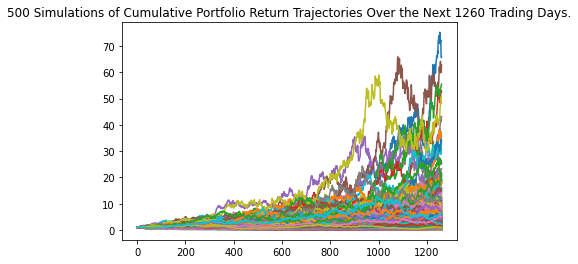

In [33]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

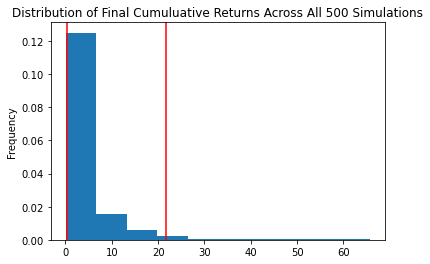

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              4.579696
std               7.569767
min               0.068581
25%               0.935060
50%               2.037006
75%               4.887923
max              65.762429
95% CI Lower      0.240063
95% CI Upper     21.628964
Name: 1260, dtype: float64


In [36]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $2400.63 and $216289.64


In [37]:
portfolio = {}
for ticker in tickers:
    stock_weight = weight_list[tickers.index(ticker)] * initial_investment
    current_stock_price = round(si.get_live_price(ticker),2)
    portfolio_weight = stock_weight//current_stock_price
    portfolio[ticker] = math.floor(portfolio_weight)

for key in portfolio.keys():
    mystring = f"Buy {key}: {portfolio[key]} shares"
    print(mystring)

Buy ROAD: 343 shares
